## PACKAGE

In [1]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from mealpy import FloatVar,GA

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt


## INPUT DATA

In [152]:
#Input Data
df = pd.read_excel(r"C:\Users\User\Downloads\Natural Gas 2025.xlsx").set_index('Date')
df.head

<bound method NDFrame.head of                 y    x1       x2       x3       x4      x5      x6     x7  \
Date                                                                        
2001-01-01   8.17   879  2096948  5609446  2676998   25547  373077   7.48   
2001-02-01   5.61   898  1910051  5240820  2309464   26882  328289   5.80   
2001-03-01   5.23   913  2116381  5041971  2246633   32121  358103   4.93   
2001-04-01   5.19   957  2028145  5252851  1807170   23637  318573   5.65   
2001-05-01   4.19   997  2070749  5749464  1522382   28981  321878   5.50   
2001-06-01   3.72  1050  1993266  6192512  1444378   24554  317414   4.64   
2001-07-01   3.11  1058  2041970  6576075  1598071   31219  364571   3.62   
2001-08-01   2.97  1032  2056737  6888848  1669178   28965  353338   3.48   
2001-09-01   2.19   972  2009185  7261934  1494128   33517  314864   2.79   
2001-10-01   2.46   913  2097034  7453778  1649073   34452  326114   2.74   
2001-11-01   2.34   825  2006035  7554750  170

## FEATURE SELECTION USING RANDOM FOREST

In [153]:
#Define X dan y
X = df.drop(columns=['y'])
y = df['y']
#Check shape
print(X.shape)
print(y.shape)

(290, 14)
(290,)


TUNING PARAMETER MTRY AND NTRY RANDOM FOREST REGRESSOR MODEL

In [154]:
#Random Forest Regressor Model Initialization
model = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=123)
# Define the parameter grid
param_grid = {
    'n_estimators': list(range(100, 1100, 100)),  # List of n_estimators from 100 to 1000
    'max_features': [2, 4, 7, 14]  # List of max_features to try
}

In [155]:
# Buat list untuk menyimpan hasil
results = []

# Loop melalui setiap kombinasi parameter
for n_estimators in param_grid['n_estimators']:
    for max_features in param_grid['max_features']:
        # Set parameter model
        model.set_params(n_estimators=n_estimators, max_features=max_features)
        
        # Latih model
        model.fit(X, y)
        
        # Hitung OOB MSE
        oob_mse = mean_squared_error(y, model.oob_prediction_)
        
        # Simpan hasilnya
        results.append({
            'n_estimators': n_estimators,
            'max_features': max_features,
            'OOB_MSE': oob_mse
        })

# Konversi hasil ke DataFrame
results_df = pd.DataFrame(results)

# Temukan kombinasi dengan OOB MSE terkecil
best_index = results_df['OOB_MSE'].idxmin()
best_params = results_df.loc[best_index, ['n_estimators', 'max_features']]
best_oob_mse = results_df.loc[best_index, 'OOB_MSE']

# Tampilkan semua hasil
print(results_df)

# Tampilkan parameter optimal dan OOB MSE terbaik
print(f"Optimal max_features (mtry): {best_params['max_features']}")
print(f"Optimal n_estimators (ntree): {best_params['n_estimators']}")
print(f"Best OOB MSE: {best_oob_mse}")

    n_estimators  max_features   OOB_MSE
0            100             2  0.427031
1            100             4  0.327494
2            100             7  0.390352
3            100            14  0.459653
4            200             2  0.433858
5            200             4  0.339579
6            200             7  0.381085
7            200            14  0.444059
8            300             2  0.430636
9            300             4  0.336480
10           300             7  0.365279
11           300            14  0.445225
12           400             2  0.422083
13           400             4  0.331900
14           400             7  0.358803
15           400            14  0.445793
16           500             2  0.417216
17           500             4  0.333587
18           500             7  0.356337
19           500            14  0.446159
20           600             2  0.414277
21           600             4  0.333563
22           600             7  0.354123
23           600

In [156]:
# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=True)

# Fit the model
grid_search.fit(X, y)

# Extract all results
results = pd.DataFrame(grid_search.cv_results_)

# Extract OOB scores for all combinations
oob_scores = []
for params in results['params']:
    model.set_params(**params)
    model.fit(X, y)
    oob_score = mean_squared_error(y, model.oob_prediction_)
    oob_scores.append(oob_score)

results['OOB_MSE'] = oob_scores


In [157]:
# Find the combination with the smallest OOB MSE
best_index = results['OOB_MSE'].idxmin()
best_params = results.loc[best_index, 'params']
best_oob_mse = results.loc[best_index, 'OOB_MSE']

# Display all results
results_to_display = results[['params', 'OOB_MSE']]
print(results_to_display)

# Results
print(f"Optimal max_features (mtry): {best_params['max_features']}")
print(f"Optimal n_estimators (ntree): {best_params['n_estimators']}")
print(f"Best OOB MSE: {best_oob_mse}")

                                        params   OOB_MSE
0     {'max_features': 2, 'n_estimators': 100}  0.427031
1     {'max_features': 2, 'n_estimators': 200}  0.433858
2     {'max_features': 2, 'n_estimators': 300}  0.430636
3     {'max_features': 2, 'n_estimators': 400}  0.422083
4     {'max_features': 2, 'n_estimators': 500}  0.417216
5     {'max_features': 2, 'n_estimators': 600}  0.414277
6     {'max_features': 2, 'n_estimators': 700}  0.414390
7     {'max_features': 2, 'n_estimators': 800}  0.413125
8     {'max_features': 2, 'n_estimators': 900}  0.411943
9    {'max_features': 2, 'n_estimators': 1000}  0.409872
10    {'max_features': 4, 'n_estimators': 100}  0.327494
11    {'max_features': 4, 'n_estimators': 200}  0.339579
12    {'max_features': 4, 'n_estimators': 300}  0.336480
13    {'max_features': 4, 'n_estimators': 400}  0.331900
14    {'max_features': 4, 'n_estimators': 500}  0.333587
15    {'max_features': 4, 'n_estimators': 600}  0.333563
16    {'max_features': 4, 'n_es

TRAIN RANDOM FOREST REGRESSOR MODEL 

In [158]:
# Train a RandomForestRegressor with best prameter : mtry 4, ntree 900
model = RandomForestRegressor(n_estimators=900, max_features=4, bootstrap=True, oob_score=True, random_state=123) 
model.fit(X,y)
# Calculate the OOB predictions
oob_predictions = model.oob_prediction_

# Calculate the MSE for OOB predictions
mse_oob = mean_squared_error(y, oob_predictions)
r2 =r2_score(y, oob_predictions)
mape_oob = mean_absolute_percentage_error(y, oob_predictions) *100
print(f'Mean Squared Error (MSE) for OOB predictions: {mse_oob:.4f}')
print(f'R-squared : {r2}')
print (f'MAPE : {mape_oob}')

Mean Squared Error (MSE) for OOB predictions: 0.3288
R-squared : 0.9303779370502862
MAPE : 8.880662400207969


In [159]:
#Create an OOB matrix
n_samples =X.shape[0]
oob_data = np.zeros((n_samples, model.n_estimators))

# Utility function to get unsampled indices
def _generate_unsampled_indices(random_state, n_samples, n_estimators):
    rng = check_random_state(random_state)
    sample_indices = rng.randint(0, n_samples, (n_estimators, n_samples))
    unsampled_indices = [np.setdiff1d(np.arange(n_samples), sample_indices[i]) for i in range(n_estimators)]
    return unsampled_indices

unsampled_indices = _generate_unsampled_indices(model.random_state, n_samples, model.n_estimators)
for i in range(model.n_estimators):
    oob_data[unsampled_indices[i], i] = 1

print("OOB Data Matrix:")
print(oob_data)

# Create a list of DataFrames for OOB samples per tree
oob_data_list = []
for i in range(model.n_estimators):
    oob_indices = unsampled_indices[i]
    oob_data_list.append(df.iloc[oob_indices])

# Assign OOB data per tree to variables qw_1, qw_2, ..., qw_900
for i, df_oob in enumerate(oob_data_list):
    globals()[f'qw_{i+1}'] = df_oob

# For demonstration, print the first few OOB samples for the first tree
print("\nFirst few OOB samples for the first tree:")
print(qw_1.head())

OOB Data Matrix:
[[1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]]

First few OOB samples for the first tree:
               y    x1       x2       x3       x4     x5      x6    x7    x8  \
Date                                                                           
2001-01-01  8.17   879  2096948  5609446  2676998  25547  373077  7.48  9.47   
2001-06-01  3.72  1050  1993266  6192512  1444378  24554  317414  4.64  3.94   
2001-10-01  2.46   913  2097034  7453778  1649073  34452  326114  2.74  2.14   
2001-12-01  2.30   754  2074278  7204251  2120198  41564  309673  2.76  2.68   
2002-02-01  2.32   679  1858737  6193791  2242427  30383  305917  2.42  2.32   

               x9    x10   x11      x12      x13    x14  
Date                                                     
2001-01-01  0.845  29.61  6.75  303.197  305.297  31.35  
2001-06-01  0.756  26.43  7.58  298.272  294.920 

In [160]:
# Create vectors yact for the actual y values from the OOB data per tree
yact = []
for i in range(model.n_estimators):
    df_oob = globals()[f'qw_{i+1}']
    yact.append(df_oob['y'])

# Create vectors ypred for the predicted y values from the OOB data per tree
ypred = []
for i in range(model.n_estimators):
    df_oob = globals()[f'qw_{i+1}']
    ypred.append(model.estimators_[i].predict(df_oob.drop(columns=['y'])))

# For demonstration, print the actual and predicted y values for the first tree
print("\nActual y values for the first tree:")
print(yact[0])

print("\nPredicted y values for the first tree:")
print(ypred[0])

c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi


Actual y values for the first tree:
Date
2001-01-01     8.17
2001-06-01     3.72
2001-10-01     2.46
2001-12-01     2.30
2002-02-01     2.32
2002-04-01     3.43
2002-09-01     3.55
2002-11-01     4.04
2003-01-01     5.43
2003-03-01     5.93
2003-07-01     5.03
2003-08-01     4.99
2003-10-01     4.63
2003-11-01     4.47
2003-12-01     6.13
2004-01-01     6.14
2004-06-01     6.27
2004-07-01     5.93
2005-01-01     6.15
2005-02-01     6.14
2005-07-01     7.63
2005-08-01     9.53
2005-12-01    13.05
2006-07-01     6.17
2007-01-01     6.55
2007-03-01     7.11
2007-04-01     7.60
2007-07-01     6.22
2007-08-01     6.22
2007-11-01     7.10
2008-02-01     8.54
2008-08-01     8.26
2008-10-01     6.74
2008-12-01     5.82
2009-06-01     3.80
2009-07-01     3.38
2009-10-01     4.01
2009-12-01     5.35
2010-07-01     4.63
2011-01-01     4.49
2011-02-01     4.09
2011-06-01     4.54
2011-12-01     3.17
2012-01-01     2.67
2012-03-01     2.17
2012-07-01     2.95
2012-11-01     3.54
2013-02-01     3.3

c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi

In [161]:
# Calculate initial MSE for each tree
mseawal_pohon = []
for i in range(model.n_estimators):
    mse = mean_squared_error(yact[i], ypred[i])
    mseawal_pohon.append(mse)

print("\nInitial MSE for each tree:")
print(mseawal_pohon)

# Predictor variables list
predictor_variables = ["x1", "x2", "x3", "x4", "x5", "x6",
                       "x7", "x8", "x9", "x10", "x11", "x12", "x13",
                       "x14"]  # Replace with actual predictor variables
num_predictors = len(predictor_variables)

# Create copies of OOB data with permuted variables for each tree
for i in range(model.n_estimators):
    for j in range(num_predictors):
        var_name = f'copy_data_tree_{i+1}_variable_{j+1}'
        globals()[var_name] = globals()[f'qw_{i+1}'].copy()

# Permute the predictor variables in the OOB data for each tree
for i in range(model.n_estimators):
    for j in range(num_predictors):
        copy_data_var_name = globals()[f'copy_data_tree_{i+1}_variable_{j+1}']
        permuted_var_name = np.random.permutation(copy_data_var_name[predictor_variables[j]])
        copy_data_var_name[predictor_variables[j]] = permuted_var_name
        globals()[f'copy_data_tree_{i+1}_variable_{j+1}'] = copy_data_var_name
        globals()[f'data_permuted_tree_{i+1}_variable_{j+1}'] = copy_data_var_name

# For demonstration, print the first few permuted OOB samples for the first tree and first variable
print("\nFirst few permuted OOB samples for the first tree and first variable:")
print(globals()['data_permuted_tree_1_variable_1'].head())


Initial MSE for each tree:
[np.float64(0.1840035714285714), np.float64(0.34727058823529405), np.float64(0.2977892857142856), np.float64(0.32198053097345125), np.float64(0.16032777777777782), np.float64(0.1950403846153846), np.float64(0.22437168141592917), np.float64(0.26937433628318586), np.float64(0.35093232323232315), np.float64(0.28479813084112154), np.float64(0.20521037735849054), np.float64(0.6825333333333333), np.float64(0.3537813725490196), np.float64(0.6088847457627117), np.float64(0.5900415841584159), np.float64(0.4772518518518518), np.float64(0.5574342592592593), np.float64(0.2720089108910891), np.float64(0.3574256880733945), np.float64(0.3892867256637167), np.float64(0.391370642201835), np.float64(0.448999107142857), np.float64(0.28579166666666667), np.float64(0.6900859649122809), np.float64(0.455485576923077), np.float64(0.22010173913043476), np.float64(0.16887614678899074), np.float64(0.3018383177570093), np.float64(0.32152566371681407), np.float64(0.352570754716981), np.

In [162]:
# Step 10: Extract the actual y values from the permuted OOB data for each tree and variable
y_act_datapermute = {}
for i in range(model.n_estimators):
    for j in range(num_predictors):
        data_asli_permutasi_var_name = globals()[f'data_permuted_tree_{i+1}_variable_{j+1}']
        y_act_datapermute[(i+1, j+1)] = data_asli_permutasi_var_name['y']

# Step 11: Predict y values using the permuted OOB data for each tree and variable
y_pred_datapermute = {}
for i in range(model.n_estimators):
    for j in range(num_predictors):
        data_asli_permutasi_var_name = globals()[f'data_permuted_tree_{i+1}_variable_{j+1}']
        X_permuted = data_asli_permutasi_var_name.drop(columns=['y'])
        y_pred_datapermute[(i+1, j+1)] = model.estimators_[i].predict(X_permuted)

# For demonstration, print a few actual and predicted y values from the permuted OOB data for the first tree and first variable
print("\nActual y values from the permuted OOB data for the first tree and first variable:")
print(y_act_datapermute[(1, 1)].head())

print("\nPredicted y values from the permuted OOB data for the first tree and first variable:")
print(y_pred_datapermute[(1, 1)][:5])


c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi


Actual y values from the permuted OOB data for the first tree and first variable:
Date
2001-01-01    8.17
2001-06-01    3.72
2001-10-01    2.46
2001-12-01    2.30
2002-02-01    2.32
Name: y, dtype: float64

Predicted y values from the permuted OOB data for the first tree and first variable:
[6.33 3.72 1.99 6.08 1.99]


c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi

In [163]:
# Step 12: Calculate MSE for the permuted OOB data for each tree and each variable
mse_datapermute = {}
for i in range(model.n_estimators):
    for j in range(num_predictors):
        y_act_datapermute_var_name = y_act_datapermute[(i+1, j+1)]
        y_pred_datapermute_var_name = y_pred_datapermute[(i+1, j+1)]
        mse = mean_squared_error(y_act_datapermute_var_name, y_pred_datapermute_var_name)
        mse_datapermute[(i+1, j+1)] = mse

# Step 13: Compute delta MSE for each tree and each variable
deltamse = {}
for i in range(model.n_estimators):
    for j in range(num_predictors):
        mse_datapermute_var_name = mse_datapermute[(i+1, j+1)]
        mseawal_var_name = mseawal_pohon[i]
        deltamse_var_name = mse_datapermute_var_name - mseawal_var_name
        deltamse[(i+1, j+1)] = deltamse_var_name

# Step 14: Calculate PVIM for each variable
vec_variabel = {}
for j in range(num_predictors):
    temp_vec = []
    for i in range(model.n_estimators):
        deltamse_var_name = deltamse[(i+1, j+1)]
        temp_vec.append(deltamse_var_name)
    vec_variabel[j+1] = temp_vec

PVIM = {}
for j in range(num_predictors):
    vec_var_name = vec_variabel[j+1]
    PVIM_var_name = np.mean(vec_var_name) 
    PVIM[j+1] = PVIM_var_name

# For demonstration, print the PVIM values
print("\nPermutation Variable Importance Measure (PVIM) for each variable:")
for j in range(num_predictors):
    print(f"Variable {j+1}: {PVIM[j+1]:.4f}")
    
print(f"\nTotal PVIM for all variables: {sum(PVIM.values()):.4f}")


Permutation Variable Importance Measure (PVIM) for each variable:
Variable 1: 0.9438
Variable 2: 0.2499
Variable 3: 0.0683
Variable 4: 0.1641
Variable 5: 0.3031
Variable 6: 0.2006
Variable 7: 1.9884
Variable 8: 2.5278
Variable 9: 0.2752
Variable 10: 0.2092
Variable 11: 0.1588
Variable 12: 0.3921
Variable 13: 0.4541
Variable 14: 0.0796

Total PVIM for all variables: 8.0149


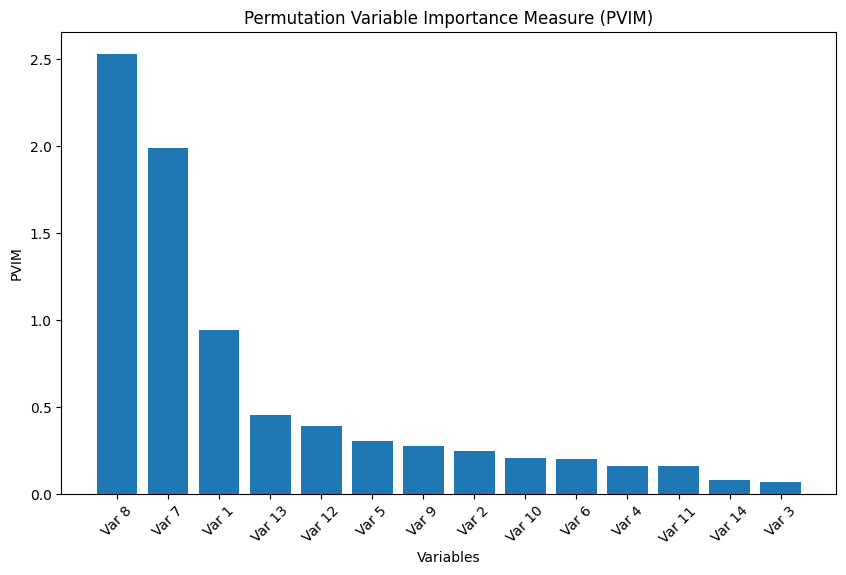

In [164]:
# Konversi PVIM ke array numpy
feature_names = list(PVIM.keys())
importances = np.array(list(PVIM.values()))
# Urutkan nilai PVIM dan nama fitur
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices]
# Plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=[f'Var {i}' for i in sorted_feature_names])
plt.xlabel('Variables')
plt.ylabel('PVIM')
plt.title('Permutation Variable Importance Measure (PVIM)')
plt.xticks(rotation=45)
plt.show()

In [165]:
# Mengurutkan PVIM berdasarkan nilai
sorted_pvim = sorted(PVIM.items(), key=lambda item: item[1], reverse=True)

# Mencetak hasil yang sudah diurutkan
print("\nPermutation Variable Importance Measure (PVIM) for each variable:")
total_pvim = sum(PVIM.values())
for var, importance in sorted_pvim:
    print(f"Variable {var}: {importance / total_pvim * 100:.4f}")



Permutation Variable Importance Measure (PVIM) for each variable:
Variable 8: 31.5387
Variable 7: 24.8087
Variable 1: 11.7756
Variable 13: 5.6656
Variable 12: 4.8921
Variable 5: 3.7815
Variable 9: 3.4337
Variable 2: 3.1176
Variable 10: 2.6097
Variable 6: 2.5029
Variable 4: 2.0477
Variable 11: 1.9816
Variable 14: 0.9926
Variable 3: 0.8519


SHOWS THE MSE RESULTS FOR EACH TREE

In [166]:
# Extract MSE values before permutation for each tree
mse_before_permutation = mseawal_pohon

# Extract MSE values after permutation for the each variable 
mse_after_permutation_xi = [mse_datapermute[(i+1, 1)] for i in range(model.n_estimators)] #ganti angka setelah i+1, jika ingin melihat tiap variabelnya

# Create a DataFrame to display the results
mse_comparison_df = pd.DataFrame({
    'Tree': range(1, model.n_estimators + 1),
    'MSE Before Permutation': mse_before_permutation,
    'MSE After Permutation (xi)': mse_after_permutation_xi
})
# Add the MSE Difference column
mse_comparison_df['MSE Difference'] = mse_comparison_df['MSE After Permutation (xi)'] - mse_comparison_df['MSE Before Permutation']

# Display the DataFrame
pd.set_option('display.max_rows', None)
mse_comparison_df # Display the first 10 rows for a preview


,Tree,MSE Before Permutation,MSE After Permutation (xi),MSE Difference
0,1,0.184004,2.155945,1.971941
1,2,0.347271,0.432496,0.085225
2,3,0.297789,1.321335,1.023546
3,4,0.321981,0.362488,0.040508
4,5,0.160328,0.941665,0.781337
5,6,0.195040,0.616278,0.421237
6,7,0.224372,1.372226,1.147854
7,8,0.269374,0.313879,0.044504
8,9,0.350932,1.375583,1.024651
9,10,0.284798,0.339593,0.054795


## SUPPORT VECTOR REGRESSION

In [168]:
#Use the data feature selected
df_fs = df.drop(['x2', 'x3','x4', 'x6','x10', 'x11', 'x14'],axis=1)
df_fs.head()

,y,x1,x5,x7,x8,x9,x12,x13
Date,,,,,,,,
2001-01-01,8.17,879,25547,7.48,9.47,0.845,303.197,305.297
2001-02-01,5.61,898,26882,5.80,6.45,0.785,272.585,272.999
2001-03-01,5.23,913,32121,4.93,5.42,0.741,301.844,302.202
2001-04-01,5.19,957,23637,5.65,5.35,0.782,288.028,287.200
2001-05-01,4.19,997,28981,5.50,4.95,0.772,290.338,289.692


## Preprocessing

MinMax scaling untuk data asli dan feature-selected
Split train test, no shuffle, 85:15

In [169]:
# Scaling data asli
scaler = MinMaxScaler().set_output(transform = 'pandas')
df_scaled = scaler.fit_transform(df.drop('y', axis = 1))
df_scaled['y'] = df['y']

# Scaling data feature selected
scaler_fs = MinMaxScaler().set_output(transform = 'pandas')
df_fs_scaled = scaler_fs.fit_transform(df_fs.drop('y', axis = 1))
df_fs_scaled['y'] = df_fs['y']

In [192]:
# Split data asli
X = df_scaled.drop('y', axis = 1)
y = df_scaled['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = False)

# Split data feature selected
X_fs = df_fs_scaled.drop('y', axis = 1)
y_fs = df_fs_scaled['y']
X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_fs, y_fs, test_size = 0.20, shuffle = False)

## Fungsi utk hitung metrics R2, RMSE, MAE

Intinya ini fungsi otomatis ngitung R2, RMSE, dan MAE buat data train dan data test

In [193]:
def compute_metrics(model, X_train, X_test, y_train, y_test):
    X_train_predict = model.predict(X_train)
    r2_train = r2_score(y_train, X_train_predict)
    rmse_train = np.sqrt(mean_squared_error(y_train, X_train_predict))
    mae_train = mean_absolute_error(y_train, X_train_predict)
    mape_train = mean_absolute_percentage_error(y_train, X_train_predict)*100

    X_test_predict = model.predict(X_test)
    r2_test = r2_score(y_test, X_test_predict)
    rmse_test = np.sqrt(mean_squared_error(y_test, X_test_predict))
    mae_test = mean_absolute_error(y_test, X_test_predict)
    mape_test = mean_absolute_percentage_error(y_test, X_test_predict)*100

    return(pd.DataFrame({'R2' : [r2_train, r2_test],
                        'RMSE' : [rmse_train, rmse_test],
                        'MAE' : [mae_train, mae_test],
                        'MAPE' : [mape_train, mape_test]},
                index = ['Train', 'Test']))

TRAIN SVR MODELS DEFAULT

In [194]:
#Train use Data Asli
svr_asli = SVR(kernel='rbf')
svr_asli.fit(X_train, y_train)

# Hitung metrics train dan test
compute_metrics(svr_asli, X_train, X_test, y_train, y_test)

,R2,RMSE,MAE,MAPE
Train,0.913270,0.649438,0.319735,6.417943
Test,0.447251,1.365905,1.072474,35.378605


In [195]:
#Train use Data Feature Selected
svr_fs = SVR(kernel='rbf')
svr_fs.fit(X_fs_train, y_fs_train)

# Hitung metrics train dan test
compute_metrics(svr_fs, X_fs_train, X_fs_test, y_fs_train, y_fs_test)

,R2,RMSE,MAE,MAPE
Train,0.931519,0.577085,0.318584,6.891579
Test,0.537353,1.249630,0.901426,26.178214


## HYBRID RF-SVR-GA MODELS

In [196]:
best_svr_fs_ga = None
best_svr_fs_ga_metric = 999

def svr_fs_fitness(parameter):
    global X_fs_train, X_fs_test, y_fs_train, y_fs_test, best_svr_fs_ga, best_svr_fs_ga_metric

    C = parameter[0]
    epsilon = parameter[1]
    gamma = parameter[2]

    svr = SVR(C = C, epsilon=epsilon, gamma = gamma, kernel='rbf', tol = 1e-5)
    svr.fit(X_fs_train, y_fs_train)

    result = compute_metrics(svr, X_fs_train, X_fs_test, y_fs_train, y_fs_test)

    # Minimumkan MAPE pada data test
    fitness = result.loc['Test', 'MAPE']

    # Simpan model terbaika
    if best_svr_fs_ga_metric > fitness:
        best_svr_fs_ga = svr
        best_svr_fs_ga_metric = fitness

    return fitness


svr_fs_hyperparameter = {
    'obj_func' : svr_fs_fitness,
    'bounds' : FloatVar(lb = [1, 0, 0], ub = [10, 5, 1]),
    'minmax' : 'max'
}

optimizer_fs = GA.BaseGA(epoch = 150, pop_size = 100, random_state = 123, pm=0.1, pc=0.8)
optimizer_fs.solve(svr_fs_hyperparameter)

# Tampilkan metrics train dan test dari model terbaik
print(compute_metrics(best_svr_fs_ga, X_fs_train, X_fs_test, y_fs_train, y_fs_test))
# show the best hyperparametes
print(best_svr_fs_ga)

2025/05/16 05:52:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


2025/05/16 05:52:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 142.51240355666025, Global best: 142.51240355666025, Runtime: 2.36716 seconds
2025/05/16 05:52:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 143.6964677123306, Global best: 143.6964677123306, Runtime: 2.47941 seconds
2025/05/16 05:52:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 143.97948642745578, Global best: 143.97948642745578, Runtime: 2.64107 seconds
2025/05/16 05:53:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 143.97948642745578, Global best: 143.97948642745578, Runtime: 1.97961 seconds
2025/05/16 05:53:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 144.01179631967432, Global best: 144.01179631967432, Runtime: 1.88426 seconds
2025/05/16 05:53:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

KeyboardInterrupt: 

## SHOW Y PREDICTIONS

In [ ]:
# Creating DataFrame with original index
y_fsga_train_predict = best_svr_fs_ga.predict(X_fs_train)
df_y_fsga_train_predict = pd.DataFrame(y_fsga_train_predict, columns=['Predicted'], index=y_fs_train.index)
df_y_fsga_train_predict

# Mengubah pengaturan tampilan untuk menampilkan semua baris
pd.set_option('display.max_rows', None)

# Menampilkan semua baris dari DataFrame
print(df_y_fsga_train_predict)

            Predicted
Date                 
2001-01-01   6.807886
2001-02-01   5.682046
2001-03-01   5.154795
2001-04-01   5.396062
2001-05-01   5.292766
2001-06-01   4.867183
2001-07-01   4.417332
2001-08-01   4.341792
2001-09-01   4.022515
2001-10-01   3.778543
2001-11-01   4.008402
2001-12-01   3.711830
2002-01-01   3.705362
2002-02-01   3.507828
2002-03-01   3.550535
2002-04-01   3.880717
2002-05-01   3.875306
2002-06-01   3.840742
2002-07-01   3.781313
2002-08-01   3.729311
2002-09-01   3.953702
2002-10-01   4.111485
2002-11-01   4.325235
2002-12-01   4.399020
2003-01-01   4.928727
2003-02-01   5.458611
2003-03-01   6.386815
2003-04-01   4.926204
2003-05-01   5.048367
2003-06-01   5.345016
2003-07-01   5.098022
2003-08-01   4.875936
2003-09-01   4.968572
2003-10-01   4.839470
2003-11-01   4.864507
2003-12-01   5.122067
2004-01-01   5.540312
2004-02-01   5.430600
2004-03-01   5.165864
2004-04-01   5.294638
2004-05-01   5.544100
2004-06-01   5.739603
2004-07-01   5.596630
2004-08-01

In [ ]:
# Creating DataFrame with original index
y_fsga_test_predict = best_svr_fs_ga.predict(X_fs_test)
df_y_fsga_test_predict = pd.DataFrame(y_fsga_test_predict, columns=['Predicted'], index=y_fs_test.index)
df_y_fsga_test_predict 

,Predicted
Date,
2020-05-01,2.274275
2020-06-01,2.113923
2020-07-01,2.133463
2020-08-01,2.293537
2020-09-01,2.411071
2020-10-01,2.484897
2020-11-01,2.790501
2020-12-01,2.828759
2021-01-01,2.821812


# Plot Trend Data Actual vs Predicted

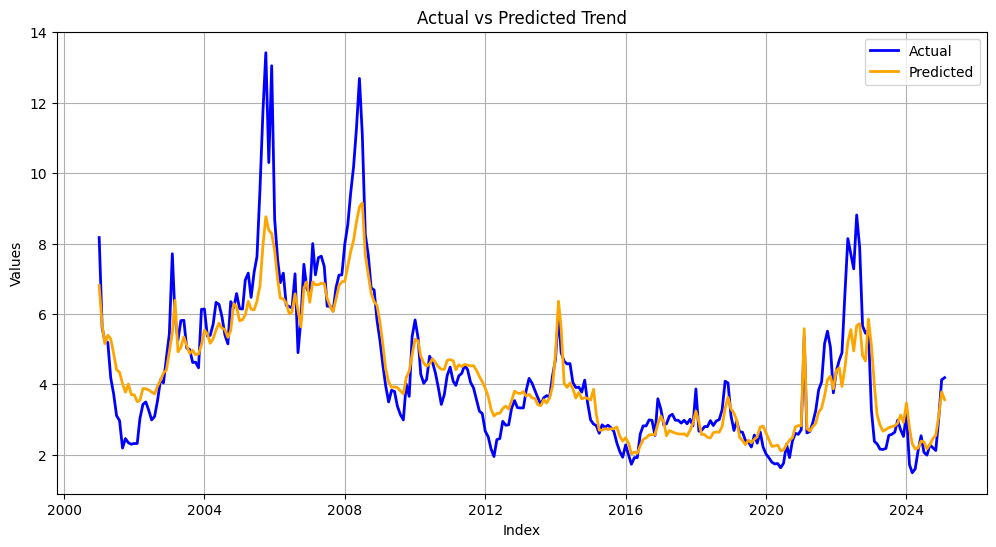

In [198]:
# Menggabungkan hasil prediksi train dan test
y_predicted = pd.concat([df_y_fsga_train_predict, df_y_fsga_test_predict])

import matplotlib.pyplot as plt

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label="Actual", color='blue', linewidth=2)
plt.plot(y_predicted.index, y_predicted, label="Predicted", color='orange',  linewidth=2)

# Pengaturan plot
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Actual vs Predicted Trend")
plt.legend()
plt.grid()

# Tampilkan grafik
plt.show()

#### Insight:
Pola data prediksi model secara langsung pada training data dan testing data memiliki bentuk yang tidak jauh berbeda dengan data asli serta sudah mulai mengikuti bentuk data asli. Oleh karena itu, dapat dikatakan bahwa model RF-SVR-GA dengan splitting ratio data 80% train data dan 20% test data dapat digunakan untuk memprediksi harga gas alam.

## HASIL PREDIKSI 3 BULAN KEDEPAN

In [ ]:
# Menghitung metrics data asli
metrics_asli = compute_metrics(svr_asli, X_train, X_test, y_train, y_test)

# Hitung metrics train dan test untuk data feature selected
metrics_fs = compute_metrics(svr_fs, X_fs_train, X_fs_test, y_fs_train, y_fs_test)

#model hybrid
# Melatih model feature selected
svr_fs_ga = SVR(C=best_svr_fs_ga.C, epsilon=best_svr_fs_ga.epsilon, gamma=best_svr_fs_ga.gamma, tol=1e-05, kernel='rbf')
svr_fs_ga.fit(X_fs_train, y_fs_train)


# Data baru untuk 3 bulan
data_baru_3_bulan = pd.DataFrame({
    'x1' :[... , ..., ...],
    'x5': [... ,... ,...],
    'x7': [... , ..., ...],
    'x8': [... , ..., ...],
    'x12': [... , ..., ...],
    'x13': [... , ..., ...],
}, index=pd.date_range(start='2025-03-01', periods=3, freq='M'))

# Pastikan kolom data baru sesuai dengan data feature selected
missing_cols = set(X_fs.columns) - set(data_baru_3_bulan.columns)
extra_cols = set(data_baru_3_bulan.columns) - set(X_fs.columns)

# Tambahkan kolom yang hilang dengan nilai 0
for col in missing_cols:
    data_baru_3_bulan[col] = 0

# Hapus kolom ekstra
data_baru_3_bulan = data_baru_3_bulan[X_fs.columns]

# Lakukan scaling pada data baru
data_baru_3_bulan_scaled = scaler_fs.transform(data_baru_3_bulan)

# Melakukan prediksi
prediksi_3_bulan = svr_fs_ga.predict(data_baru_3_bulan_scaled)

# Menggabungkan hasil prediksi dengan index (tanggal)
hasil_prediksi = pd.DataFrame(prediksi_3_bulan, index=data_baru_3_bulan.index, columns=['Prediksi_y'])

print("Metrics untuk model asli:")
print(metrics_asli)

print("\nMetrics untuk model dengan fitur yang dipilih:")
print(metrics_fs)

print("\nHasil prediksi untuk 3 bulan ke depan:")
print(hasil_prediksi)